In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/depth_est_model'
%pwd

[Errno 2] No such file or directory: 'drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/depth_est_model'
/content


'/content'

In [ ]:
import os
import cv2
import pandas as pd
import torch

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (11718/11718), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.4/898.4 kB 24.4 MB/s eta 0:00:00


In [ ]:
%pwd

'/content/yolov5'

In [ ]:
import torch
import os
import cv2
import pandas as pd
import pathlib

pathlib.WindowsPath = pathlib.PosixPath
# Load model
# model = torch.hub.load('ultralytics/yolov5', 'custom', path='../yolov5/runs/train/exp9/weights/best.pt')
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/depth_est_model/best.pt')

# model = torch.load('my_full_model.pt')
model.eval()

# Directory containing test images
test_dir = '/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/depth_est_model/processed_dataset/images/test'
save_dir = '/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/depth_est_model/processed_dataset/results'
os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

# Path for the consolidated CSV file
combined_csv_path = os.path.join(save_dir, "combined_results.csv")

# Function to calculate bounding box sizes
def calculate_bounding_boxes(detections):
    detections['width'] = detections['xmax'] - detections['xmin']
    detections['height'] = detections['ymax'] - detections['ymin']
    return detections

# Function to visualize bounding boxes
def visualize_bounding_boxes(image_path, detection):
    # Load the image
    image = cv2.imread(image_path)

    # Extract bounding box details
    xmin, ymin, xmax, ymax = int(detection['xmin']), int(detection['ymin']), int(detection['xmax']), int(detection['ymax'])
    width, height = detection['width'], detection['height']
    class_name = detection['name']
    confidence = detection['confidence']

    # Draw the bounding box
    cv2.rectangle(image, (xmin+((xmax-xmin)//2), ymin+((ymax-ymin)//2)), (xmax+((xmax-xmin)//2), ymax+((ymax-ymin)//2)), (0, 255, 0), 2)  # Green box

    # Label with class name and size
    label = f"{class_name} ({width:.0f}x{height:.0f}) {confidence:.2f}"
    cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Save the annotated image
    output_path = os.path.join(save_dir, f"{os.path.basename(image_path)}_result.jpg")
    cv2.imwrite(output_path, image)
    print(f"Saved annotated image to {output_path}")


# Initialize a list to store all detection DataFrames
all_detections = []

img_to_process = "13.jpg"
# Process a maximum of 100 images
# image_count = 0
# for file in os.listdir(test_dir):
file_path = os.path.join(test_dir, img_to_process)

# Ensure it's a valid image file
# if file.lower().endswith(('.jpg', '.jpeg', '.png')):
print(f"Processing {file_path}")

# Perform inference
results = model(file_path)
detections = results.pandas().xyxy[0]  # Get bounding box details as DataFrame

# Filter detections for coins only
coin_detections = detections[(detections['name'] == 'coin')]

# Check if there are any valid detections
if not coin_detections.empty:
    # Select the detection with the highest confidence
    highest_confidence_detection = coin_detections.loc[coin_detections['confidence'].idxmax()]

    # Convert the Series to a DataFrame for processing
    highest_confidence_detection = highest_confidence_detection.to_frame().T

    # Add filename column for traceability
    highest_confidence_detection['image_name'] = img_to_process

    # Calculate bounding box sizes
    highest_confidence_detection = calculate_bounding_boxes(highest_confidence_detection)

    # Append the highest confidence detection to the list
    all_detections.append(highest_confidence_detection)

    # Visualize and save the image with the highest confidence bounding box
    visualize_bounding_boxes(file_path, highest_confidence_detection.iloc[0])
else:
    print(f"No coins detected in {file_path}")

one_dollar_dimensions = {"diameter":2.465}
# to be replaced
plate_pixels =  {"pixels":1000}
# Combine all detections into a single DataFrame
if all_detections:
    # coin diameters in pixels in picture
    diameter_in_pixels = (all_detections[0].at[0,'width'] + all_detections[0].at[0,'height'])/2
    plate_diameter_in_cm = plate_pixels["pixels"]/diameter_in_pixels*one_dollar_dimensions['diameter']
    # combined_detections = pd.concat(all_detections, ignore_index=True)
    # combined_detections.to_csv(combined_csv_path, index=False)
    print("the diameter of the coin in pixels is: "+str(diameter_in_pixels) +". We take the diameter of the plate in pixels/diameter of the coin in pixels and multiply with known size of one dollar coin to get: " + str(plate_diameter_in_cm))
    # print(f"Saved combined results to {combined_csv_path}")
else:
    print("No detections to save.")


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-12-6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



Exception: [Errno 2] No such file or directory: '/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/depth_est_model/best.pt'. Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.

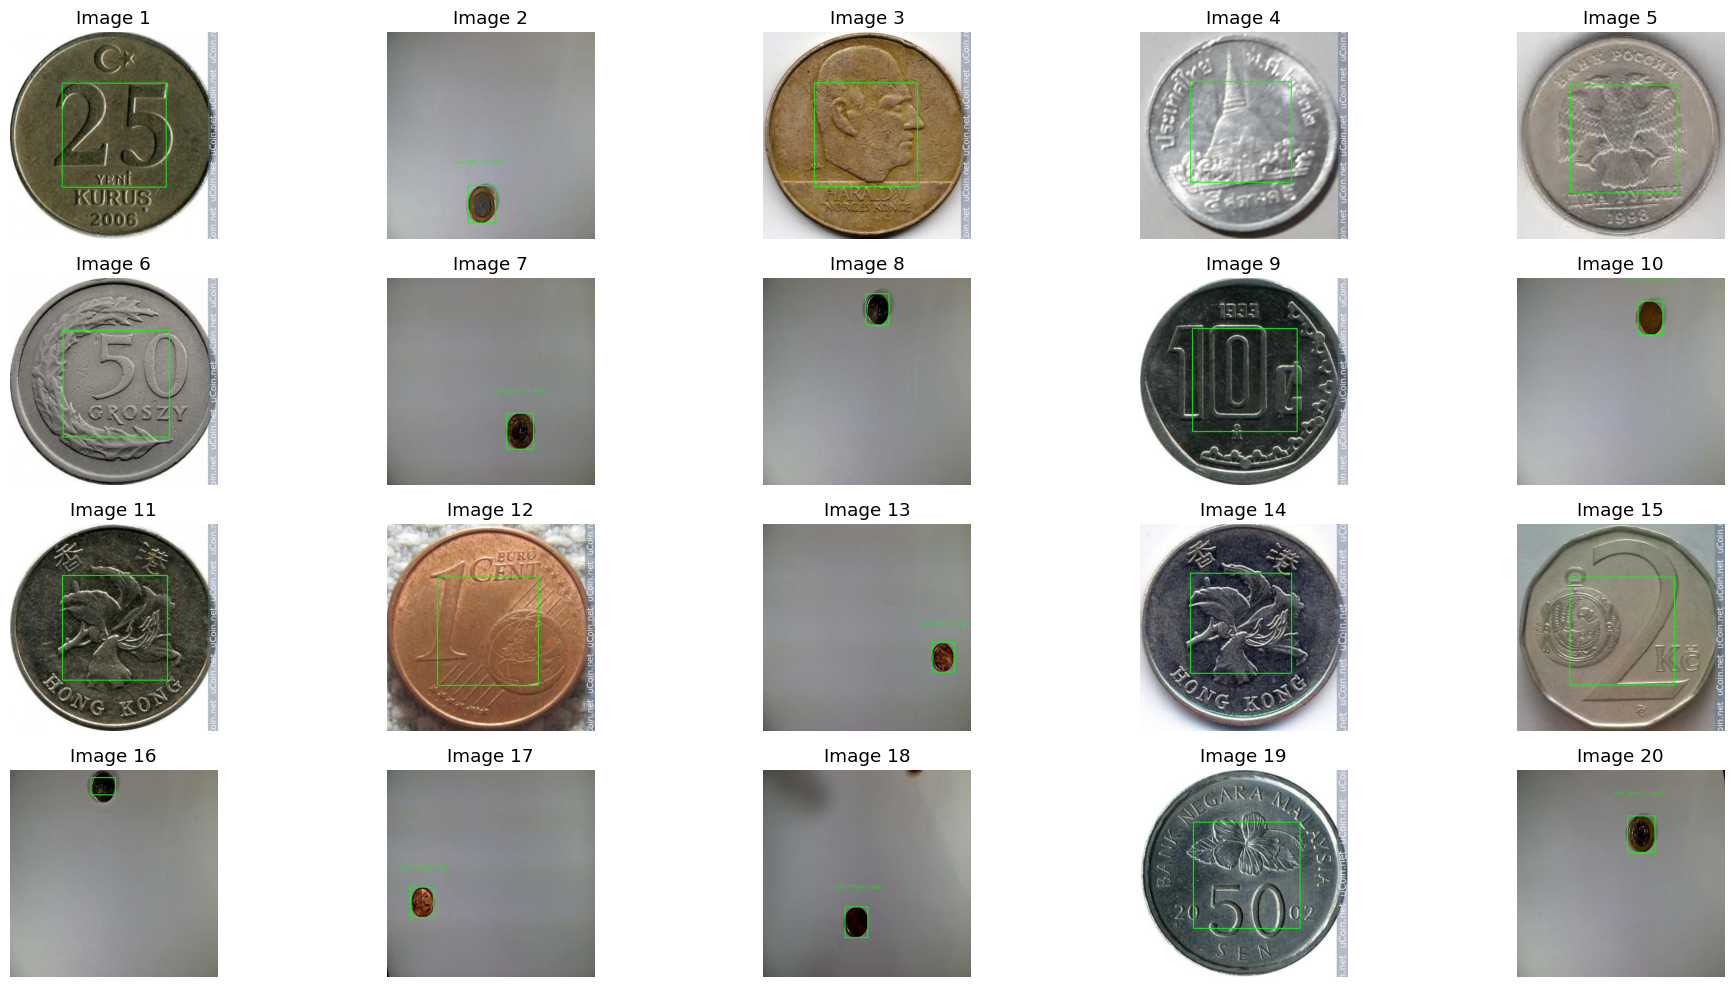

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Define the folder path
results_path = '/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/depth_est_model/processed_dataset/results'

# List all files in the folder
files = os.listdir(results_path)

# Filter for image files (jpg, jpeg, png)
image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Sort the files for consistency
image_files.sort()

num_results_to_plot = min(20, len(image_files))
plt.figure(figsize=(20, 10))

for i, image_file in enumerate(image_files[:num_results_to_plot], start=1):
    # Load the image
    image_path = os.path.join(results_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV format) to RGB (matplotlib format)

    # Plot the image
    plt.subplot(4, 5, i)  # Create a grid for 20 images (4 rows x 5 columns)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {i}")

plt.tight_layout()
plt.show()